In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [3]:
# Build the model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation="relu")
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)

    def call(self, inputs, training=True):
        x = self.dense_1(inputs)
        if(training):
            x = self.dropout(x)
        return self.dense_2(x)


class MyModelSoftmax(Model):
    def __init__(self):
        super(MyModelSoftmax, self).__init__()
        self.dense_1 = Dense(64, activation="relu")
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()

    def call(self, inputs, training=True):
        x = self.dense_1(inputs)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        concat = concatenate([x, y2])
        return self.softmax(concat)

In [4]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10]))
print(model.summary())

model = MyModelSoftmax()
model(tf.random.uniform([1, 10]))
print(model.summary())

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________
None
Model: "my_model_softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  704       
_________________________________________________________________
dense_3 (Dense)              multiple                  110       
_________________________

***
<a id="coding_tutorial_2"></a>
## Custom layers

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [6]:
# Create a custom layer
class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(
            shape=(input_dim, units),
            initializer="random_normal"
        )
        self.b = self.add_weight(
            shape=(units,),
            initializer="zeros"
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))

print(dense_layer(x))
print(dense_layer.weights)


tf.Tensor([[-0.06863484 -0.16181874 -0.00378563]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.07629082, -0.00094473, -0.02077869],
       [ 0.02954525, -0.05300635,  0.00250924],
       [-0.02157235, -0.04234963, -0.02525771],
       [-0.09619235, -0.07512807, -0.00764575],
       [-0.05670621,  0.00961005,  0.04738728]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [7]:
# Specify trainable weights
# Create a custom layer
class MyLayerNonTrainable(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerNonTrainable, self).__init__()
        self.w = self.add_weight(
            shape=(input_dim, units),
            initializer="random_normal",
            trainable=False
        )
        self.b = self.add_weight(
            shape=(units,),
            initializer="zeros",
            trainable=False
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer_nt = MyLayerNonTrainable(3, 5)

In [8]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

print('trainable weights:', len(dense_layer_nt.trainable_weights))
print('non-trainable weights:', len(dense_layer_nt.non_trainable_weights))

trainable weights: 2
non-trainable weights: 0
trainable weights: 0
non-trainable weights: 2


In [9]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(
            shape=(input_dim, units),
            initializer="random_normal"
        )
        self.b = self.add_weight(
            shape=(units,),
            initializer="zeros"
        )

        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)), trainable=False)
        self.number_call = tf.Variable(initial_value=0, trainable=False)

    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])

        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3, 5)

In [10]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.03554245 -0.16925289  0.00829015]
[-0.03554245 -0.16925289  0.00829015]


In [11]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [12]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):
    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        
        return self.softmax(x)

In [13]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01654819 0.01406919 0.01896381 0.01517388 0.01846443 0.02656098
  0.02007517 0.02103433 0.0078622  0.01281202 0.02818001 0.01297373
  0.04092837 0.01148728 0.02317696 0.01894369 0.01402895 0.02559477
  0.01827386 0.02707118 0.02068591 0.03187777 0.01700598 0.01702556
  0.03920012 0.02428981 0.04694604 0.01864179 0.01909704 0.01523195
  0.01639857 0.0182145  0.01924307 0.03345661 0.0463209  0.03615499
  0.0087196  0.0214375  0.02204743 0.01596831 0.01735505 0.02276595
  0.01604119 0.02166872 0.02019678 0.02178581]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_1 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_2 (MyLaye

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

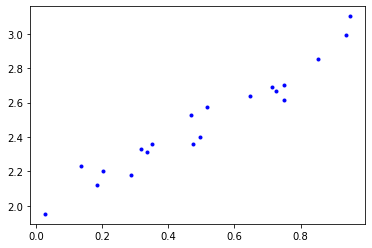

In [15]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [16]:
from tensorflow.keras.layers import Layer

In [25]:
# Build a custom layer for the linear regression model
class LinearLayer(Layer):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(
            shape=(1,),
            initializer="random_normal"
        )
        self.b = self.add_weight(
            shape=(1,),
            initializer="zeros"
        )

    def call(self, inputs):
        return inputs * self.m + self.b

linear_regression = LinearLayer()
print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[-0.00470546 -0.0095464  -0.00038684 -0.00383611 -0.01141224 -0.00632763
 -0.00247913 -0.0026948  -0.01267735 -0.00663534 -0.01002391 -0.00449449
 -0.00970709 -0.00423436 -0.01003065 -0.00625807 -0.01254155 -0.00864361
 -0.00183101 -0.00691077], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.01336368], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [26]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.322496


#### Train and plot the model

In [27]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions, y_train)

    gradients = tape.gradient(loss, linear_regression.trainable_variables)

    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[0])

    print(f"Step {i}, Loss {loss.numpy()}")

Step 0, Loss 6.322495937347412
Step 1, Loss 5.334902286529541
Step 2, Loss 4.503734111785889
Step 3, Loss 3.804098606109619
Step 4, Loss 3.2150726318359375
Step 5, Loss 2.719071626663208
Step 6, Loss 2.301313877105713
Step 7, Loss 1.9493744373321533
Step 8, Loss 1.6528087854385376
Step 9, Loss 1.4028360843658447
Step 10, Loss 1.1920734643936157
Step 11, Loss 1.014312982559204
Step 12, Loss 0.864334762096405
Step 13, Loss 0.7377492785453796
Step 14, Loss 0.6308642625808716
Step 15, Loss 0.5405739545822144
Step 16, Loss 0.46426576375961304
Step 17, Loss 0.3997412919998169
Step 18, Loss 0.3451509475708008
Step 19, Loss 0.2989378273487091
Step 20, Loss 0.2597915530204773
Step 21, Loss 0.22660882771015167
Step 22, Loss 0.1984606236219406
Step 23, Loss 0.1745642125606537
Step 24, Loss 0.15426048636436462


m:1,  trained m:[1.4117224]
b:2,  trained b:[1.4250861]


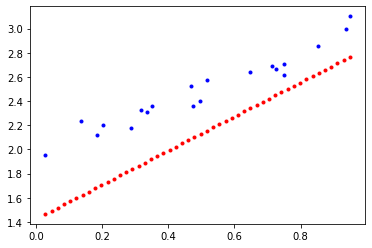

In [28]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [38]:
# Define the custom layers and model
class MyLayer(Layer):
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            name="kernel"
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            name="bias"
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):
    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)        

class MyModel(Model):
    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        
        return self.softmax(x)

In [39]:
model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01433084 0.04453395 0.01644428 0.02813552 0.04682855 0.00826616
  0.03259973 0.01586106 0.02504858 0.00740894 0.00406059 0.02623343
  0.01100531 0.03117743 0.01747277 0.01833814 0.01625166 0.01648653
  0.01231879 0.0099944  0.01029817 0.03084548 0.04714942 0.01202203
  0.00612816 0.01125678 0.12197806 0.01085696 0.00640115 0.01289381
  0.05051681 0.01978822 0.03972178 0.01111032 0.04687312 0.03636114
  0.0154411  0.00407456 0.00808444 0.00248901 0.02265412 0.02564897
  0.00690625 0.00649393 0.02226194 0.00894754]], shape=(1, 46), dtype=float32)
Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_7 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_4 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_8 (MyLaye

#### Load the reuters dataset and define the class_names 

In [40]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [41]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [42]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [43]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [44]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [45]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [46]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [50]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Compute current losss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

    # End Epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print(f"Epoch {epoch:03d}, Loss: {epoch_loss_avg.result():.3f}, Accuracy: {epoch_accuracy.result():.3%}")
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000, Loss: 1.921, Accuracy: 60.744%
Epoch 001, Loss: 1.829, Accuracy: 64.318%
Epoch 002, Loss: 1.789, Accuracy: 66.255%
Epoch 003, Loss: 1.765, Accuracy: 67.724%
Epoch 004, Loss: 1.739, Accuracy: 68.069%
Epoch 005, Loss: 1.729, Accuracy: 68.927%
Epoch 006, Loss: 1.724, Accuracy: 69.227%
Epoch 007, Loss: 1.706, Accuracy: 70.007%
Epoch 008, Loss: 1.710, Accuracy: 70.207%
Epoch 009, Loss: 1.713, Accuracy: 70.118%
Duration :86.492


#### Evaluate the model

In [51]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [52]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [53]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.847
Test accuracy: 67.676%


#### Plot the learning curves

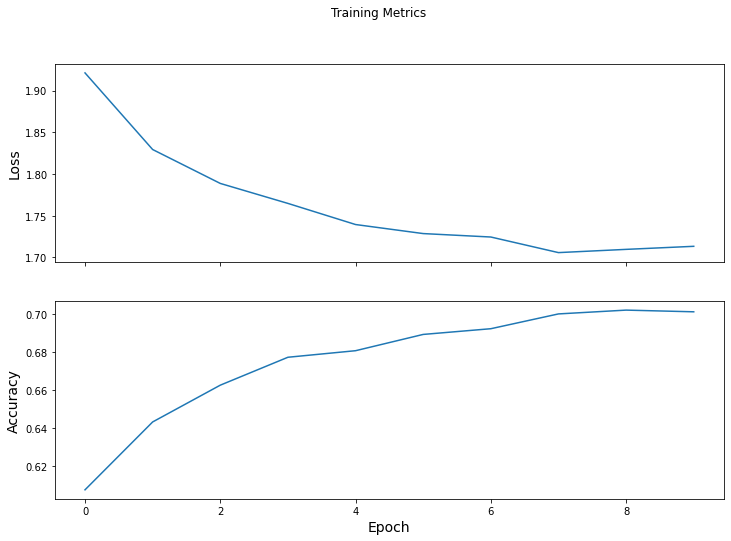

In [54]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [55]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [57]:
# Initialize a new model
model = MyModel(64, 64, 46)



#### Redefine the grad function using the @tf.function decorator

In [58]:
# Use the @tf.function decorator
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [59]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Compute current losss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

    # End Epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print(f"Epoch {epoch:03d}, Loss: {epoch_loss_avg.result():.3f}, Accuracy: {epoch_accuracy.result():.3%}")
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000, Loss: 2.426, Accuracy: 57.816%
Epoch 001, Loss: 1.911, Accuracy: 67.045%
Epoch 002, Loss: 1.831, Accuracy: 68.437%
Epoch 003, Loss: 1.773, Accuracy: 69.005%
Epoch 004, Loss: 1.750, Accuracy: 68.849%
Epoch 005, Loss: 1.750, Accuracy: 69.895%
Epoch 006, Loss: 1.711, Accuracy: 69.962%
Epoch 007, Loss: 1.711, Accuracy: 70.430%
Epoch 008, Loss: 1.700, Accuracy: 70.307%
Epoch 009, Loss: 1.697, Accuracy: 70.341%
Duration :69.204


#### Print the autograph code

In [60]:
# Use tf.autograph.to_code to see the generated code
print(tf.autograph.to_code(grad.python_function))


def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

